In [1]:
import tensorflow as tf

# Load Fashion MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# Combine training and testing sets for federated learning setup
data_set = list(zip(train_images, train_labels))


2024-07-09 21:32:37.379486: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-09 21:32:38.185828: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-09 21:32:38.188149: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-09 21:32:39.366234: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-09 21:32:46.228938: W tensorflow/compiler/tf

In [2]:
import tensorflow as tf
import numpy as np

# Load Fashion MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# Define the desired classes (e.g., 0 for T-shirt/top and 1 for Trouser)
desired_classes = [0, 1]

# Filter the training set
train_filter = np.isin(train_labels, desired_classes)
filtered_train_images = train_images[train_filter]
filtered_train_labels = train_labels[train_filter]

# Filter the test set (if needed)
test_filter = np.isin(test_labels, desired_classes)
filtered_test_images = test_images[test_filter]
filtered_test_labels = test_labels[test_filter]

# Combine training and testing sets for federated learning setup (if needed)
data_set = list(zip(filtered_train_images, filtered_train_labels))
# You can also include the test set
# data_set = list(zip(filtered_train_images, filtered_train_labels)) + list(zip(filtered_test_images, filtered_test_labels))

print(f"Number of samples in the filtered train set: {len(filtered_train_images)}")
print(f"Number of samples in the filtered test set: {len(filtered_test_images)}")

# Preprocess images
def preprocess_image(image):
    return image.astype(np.float32) / 255.0

def reduce_features(flat_image, word_size):
    # Split the flat_image into segments of word_size and average each segment
    reduced_image = [np.mean(flat_image[i:i+word_size]) for i in range(0, len(flat_image), word_size)]
    return np.array(reduced_image)

word_size = 196  # 784 features / 196 = 4 features

# Preprocess the training set
np_data_set = []
for image, label in data_set:
    image = preprocess_image(image)
    flat_image = image.flatten()
    reduced_image = reduce_features(flat_image, word_size)
    data_point = {'image': reduced_image, 'label': label}
    np_data_set.append(data_point)

print("First 5 samples of encoded data:")
print(np_data_set[:5])


Number of samples in the filtered train set: 12000
Number of samples in the filtered test set: 2000
First 5 samples of encoded data:
[{'image': array([0.4398359 , 0.48689476, 0.38769507, 0.37821126], dtype=float32), 'label': 0}, {'image': array([0.16340536, 0.13731493, 0.14341737, 0.12933174], dtype=float32), 'label': 0}, {'image': array([0.2477591 , 0.29791918, 0.34525812, 0.33329332], dtype=float32), 'label': 0}, {'image': array([0.40828332, 0.35956386, 0.28741497, 0.33653462], dtype=float32), 'label': 0}, {'image': array([0.30466187, 0.279972  , 0.24277712, 0.21536615], dtype=float32), 'label': 1}]


In [3]:
# Shuffle the dataset
np.random.shuffle(np_data_set)

print("First 5 samples of encoded shuffled data:")
print(np_data_set[:5])

First 5 samples of encoded shuffled data:
[{'image': array([0.33317327, 0.4396959 , 0.27961186, 0.26740697], dtype=float32), 'label': 0}, {'image': array([0.44441774, 0.3304722 , 0.20038018, 0.31540617], dtype=float32), 'label': 0}, {'image': array([0.20018005, 0.22805125, 0.1752101 , 0.15030013], dtype=float32), 'label': 1}, {'image': array([0.42344937, 0.40644255, 0.35218087, 0.34823927], dtype=float32), 'label': 0}, {'image': array([0.1517207 , 0.14955984, 0.13401361, 0.11362545], dtype=float32), 'label': 1}]


In [4]:
print(len(np_data_set))

12000


In [5]:
np_train_data = np_data_set[:10000]
np_test_data = np_data_set[-2000:]

print(f"Length of np_train_data: {len(np_train_data)}")
print(f"Length of np_test_data: {len(np_test_data)}")

test_image = [data_point["image"] for data_point in np_test_data]
test_labels = [data_point["label"] for data_point in np_test_data]
test_image = np.array(test_image)
test_labels = np.array(test_labels)

Length of np_train_data: 10000
Length of np_test_data: 2000


In [24]:
import time
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.primitives import BackendSampler
from functools import partial
#from qiskit import IBMQ
from qiskit.providers.basic_provider import BasicProvider


num_clients = 4   #5
num_epochs = 5  #25
max_train_iterations = 10
samples_per_epoch= 100
#backend = Aer.get_backend('aer_simulator')
backend = BasicProvider().get_backend("basic_simulator")


fl_avg_weight_range = [0.1, 1]


In [25]:
class Client:
    def __init__(self, data):
        self.models = []
        self.primary_model = None
        self.data = data
        self.test_scores = []
        self.train_scores = []

def split_dataset(num_clients, num_epochs, samples_per_epoch):
  clients = []
  for i in range(num_clients):
    client_data = []
    for j in range(num_epochs):
      start_idx = (i*num_epochs*samples_per_epoch)+(j*samples_per_epoch)
      end_idx = (i*num_epochs*samples_per_epoch)+((j+1)*samples_per_epoch)
      client_data.append(np_train_data[start_idx:end_idx])
    clients.append(Client(client_data))
  return clients

clients = split_dataset(num_clients, num_epochs, samples_per_epoch)

clients[0].data[0][:3]



[{'image': array([0.33317327, 0.4396959 , 0.27961186, 0.26740697], dtype=float32),
  'label': 0},
 {'image': array([0.44441774, 0.3304722 , 0.20038018, 0.31540617], dtype=float32),
  'label': 0},
 {'image': array([0.20018005, 0.22805125, 0.1752101 , 0.15030013], dtype=float32),
  'label': 1}]

In [26]:
import time

itr = 0
def training_callback(weights, obj_func_eval):
        global itr
        itr += 1
        print(f"{itr}", end=' | ')

def train(data, model = None):
  if model is None:
    num_features = len(data[0]["image"])
    feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
    ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
    optimizer = COBYLA(maxiter=max_train_iterations)
    vqc_model = VQC(
        feature_map=feature_map,
        ansatz=ansatz,
        optimizer=optimizer,
        callback=partial(training_callback),
        sampler=BackendSampler(backend=backend),
        warm_start=True
    )
    model = vqc_model

  train_image = [data_point["image"] for data_point in data]
  train_labels = [data_point["label"] for data_point in data]

  # Convert the lists to NumPy arrays
  train_image = np.array(train_image)
  train_labels = np.array(train_labels)

  # Print the shapes
  print("Train image Shape:", train_image.shape)
  print("Train Labels Shape:", train_labels.shape)

  print("Training Started")
  start_time = time.time()
  model.fit(train_image, train_labels)
  end_time = time.time()
  elapsed_time = end_time - start_time
  print(f"\nTraining complete. Time taken: {elapsed_time} seconds.")

  print(f"SCORING MODEL")
  train_score_q = model.score(train_image, train_labels)
  test_score_q = model.score(test_image, test_labels)
  return train_score_q, test_score_q, model





In [27]:
def getAccuracy(weights, test_num = 200):
        num_features = len(test_image[0])
        feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
        ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
        optimizer = COBYLA(maxiter=0)
        vqc = VQC(
            feature_map=feature_map,
            ansatz=ansatz,
            optimizer=optimizer,
            sampler=BackendSampler(backend=backend),
            initial_point = weights
        )
        vqc.fit(test_image[:25], test_labels[:25])
        return vqc.score(test_image[:test_num], test_labels[:test_num])

def create_model_with_weights(weights):
  num_features = len(test_image[0])
  feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
  ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
  optimizer = COBYLA(maxiter=max_train_iterations)
  vqc = VQC(
      feature_map=feature_map,
      ansatz=ansatz,
      optimizer=optimizer,
      sampler=BackendSampler(backend=backend),
      warm_start = True,
      initial_point  = weights,
      callback=partial(training_callback)
  )
  return vqc

In [28]:
import warnings

# Temporary code to suppress all FutureWarnings for a cleaner output
warnings.simplefilter("ignore", FutureWarning)


In [29]:
import numpy as np

def sort_epoch_results(epoch_results):
    # Pair weights and test_scores together
    pairs = zip(epoch_results['weights'], epoch_results['test_scores'])

    # Sort the pairs based on test_scores
    sorted_pairs = sorted(pairs, key=lambda x: x[1])

    # Unzip the sorted pairs back into separate arrays
    sorted_weights, sorted_test_scores = zip(*sorted_pairs)

    # Create a new sorted dictionary
    sorted_epoch_results = {
        'weights': list(sorted_weights),
        'test_scores': list(sorted_test_scores)
    }

    return sorted_epoch_results
fl_avg_weight_range = [0.1, 1]

def scale_test_scores(sorted_epoch_results):
    min_test_score = sorted_epoch_results['test_scores'][0]
    max_test_score = sorted_epoch_results['test_scores'][-1]
    min_weight, max_weight = fl_avg_weight_range
    scaled_weights = [
        min_weight + (max_weight - min_weight) * (test_score - min_test_score) / (max_test_score - min_test_score)
        for test_score in sorted_epoch_results['test_scores']
    ]
    sorted_epoch_results['fl_avg_weights'] = scaled_weights
    return sorted_epoch_results

def calculate_weighted_average(model_weights, fl_avg_weights):
    weighted_sum_weights = []
    for index in range(len(model_weights[0])):
      weighted_sum_weights.append(0)
      weighted_sum_weights[index] = sum([(weights_array[index]* avg_weight) for weights_array, avg_weight  in zip(model_weights, fl_avg_weights)])/sum(fl_avg_weights)
    return weighted_sum_weights

def weighted_average(epoch_results, global_model_weights_last_epoch = None, global_model_accuracy_last_epoch = None):
  if(global_model_weights_last_epoch != None):
    epoch_results['weights'].append(global_model_weights_last_epoch)
    epoch_results['test_scores'].append(global_model_accuracy_last_epoch)
  epoch_results = sort_epoch_results(epoch_results)
  epoch_results = scale_test_scores(epoch_results)
  print(epoch_results)
  weighted_average_weights_curr_epoch = calculate_weighted_average(epoch_results['weights'], epoch_results['fl_avg_weights'])
  return weighted_average_weights_curr_epoch



def weighted_average_best_pick(epoch_results, global_model_weights_last_epoch = None, global_model_accuracy_last_epoch = None, best_pick_cutoff = 0.5):
  if(global_model_weights_last_epoch != None):
    epoch_results['weights'].append(global_model_weights_last_epoch)
    epoch_results['test_scores'].append(global_model_accuracy_last_epoch)

  epoch_results = sort_epoch_results(epoch_results)
  epoch_results = scale_test_scores(epoch_results)

  new_weights = []
  new_test_scores = []
  new_fl_avg_weights = []

  for index, fl_avg_weight in enumerate(epoch_results['fl_avg_weights']):
      if fl_avg_weight >= best_pick_cutoff:
          new_weights.append(epoch_results['weights'][index])
          new_test_scores.append(epoch_results['test_scores'][index])
          new_fl_avg_weights.append(fl_avg_weight)

  # Update the epoch_results dictionary with the new lists
  epoch_results['weights'] = new_weights
  epoch_results['test_scores'] = new_test_scores
  epoch_results['fl_avg_weights'] = new_fl_avg_weights

  print(epoch_results)
  weighted_average_weights_curr_epoch = calculate_weighted_average(epoch_results['weights'], epoch_results['fl_avg_weights'])
  return weighted_average_weights_curr_epoch

def simple_averaging(epoch_results, global_model_weights_last_epoch = None, global_model_accuracy_last_epoch = None):
  if(global_model_weights_last_epoch != None):
    epoch_results['weights'].append(global_model_weights_last_epoch)
    epoch_results['test_scores'].append(global_model_accuracy_last_epoch)

  epoch_weights = epoch_results['weights']
  averages = []
  # Iterate through the columns (i.e., elements at the same position) of the arrays
  for col in range(len(epoch_weights[0])):
      # Initialize a variable to store the sum of elements at the same position
      col_sum = 0
      for row in range(len(epoch_weights)):
          col_sum += epoch_weights[row][col]

      # Calculate the average for this column and append it to the averages list
      col_avg = col_sum / len(epoch_weights)
      averages.append(col_avg)

  return averages



In [30]:
fl_techniques = {
    'Averaging': simple_averaging,
    'Weighted_Averaging': weighted_average,
    'Best_Pick_Weighted_Averaging': weighted_average_best_pick
}
clients_2d_array = [[] for _ in range(len(fl_techniques))]

for index, (technique_name, _) in enumerate(fl_techniques.items()):
        for client in clients:
          client_copy = Client(client.data)
          clients_2d_array[index].append(client_copy)


clients_2d_array

[[<__main__.Client at 0x7fb230fc2840>,

In [31]:
global_model_weights = []
global_model_accuracy = []



for outer_idx, clients in enumerate(clients_2d_array):
  technique_name = list(fl_techniques.keys())[outer_idx]
  technique_function = list(fl_techniques.values())[outer_idx]
  print(f"Technique Name: {technique_name}")
  global_model_weights.append([])
  global_model_accuracy.append([])
  for epoch in range(num_epochs):
    epoch_results = {
        'weights': [],
        'test_scores': []
    }
    print(f"epoch: {epoch}")

    for index, client in enumerate(clients):
      print(f"Index: {index}, Client: {client}")

      if client.primary_model is None:
        train_score_q, test_score_q, model = train(data = client.data[epoch])
        client.models.append(model)
        client.test_scores.append(test_score_q)
        client.train_scores.append(train_score_q)
        # Print the values
        print("Train Score:", train_score_q)
        print("Test Score:", test_score_q)
        print("\n\n")
        epoch_results['weights'].append(model.weights)
        epoch_results['test_scores'].append(test_score_q)

      else:
        train_score_q, test_score_q, model = train(data = client.data[epoch], model = client.primary_model)
        client.models.append(model)
        client.test_scores.append(test_score_q)
        client.train_scores.append(train_score_q)
        print("Train Score:", train_score_q)
        print("Test Score:", test_score_q)
        print("\n\n")
        epoch_results['weights'].append(model.weights)
        epoch_results['test_scores'].append(test_score_q)

    new_global_weights = []
    if(epoch == 0):
      new_global_weights = technique_function(epoch_results)
    else:
      new_global_weights = technique_function(epoch_results, global_model_weights[outer_idx][epoch - 1], global_model_accuracy[outer_idx][epoch - 1])
    print(new_global_weights)
    global_model_weights[outer_idx].append(new_global_weights)
    new_model_with_global_weights = create_model_with_weights(global_model_weights[outer_idx][epoch])

    for index, client in enumerate(clients):
      client.primary_model = new_model_with_global_weights

    global_accuracy = getAccuracy(global_model_weights[outer_idx][epoch], len(test_image))
    global_model_accuracy[outer_idx].append(global_accuracy)
    print(f"Technique Name: {technique_name}")
    print(f"Global Model Accuracy In Epoch {epoch}: {global_accuracy}")
    print("----------------------------------------------------------")



Technique Name: Averaging
epoch: 0
Index: 0, Client: <__main__.Client object at 0x7fb230fc2840>
Train image Shape: (100, 4)
Train Labels Shape: (100,)
Training Started
1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 
Training complete. Time taken: 8.202359914779663 seconds.
SCORING MODEL
Train Score: 0.66
Test Score: 0.5905



Index: 1, Client: <__main__.Client object at 0x7fb24fa58da0>
Train image Shape: (100, 4)
Train Labels Shape: (100,)
Training Started
11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 | 
Training complete. Time taken: 9.817040920257568 seconds.
SCORING MODEL
Train Score: 0.64
Test Score: 0.61



Index: 2, Client: <__main__.Client object at 0x7fb24fa58d70>
Train image Shape: (100, 4)
Train Labels Shape: (100,)
Training Started
21 | 22 | 23 | 24 | 25 | 26 | 27 | 28 | 29 | 30 | 
Training complete. Time taken: 10.617609739303589 seconds.
SCORING MODEL
Train Score: 0.55
Test Score: 0.558



Index: 3, Client: <__main__.Client object at 0x7fb24fa5a810>
Train image Shape: (100, 4)

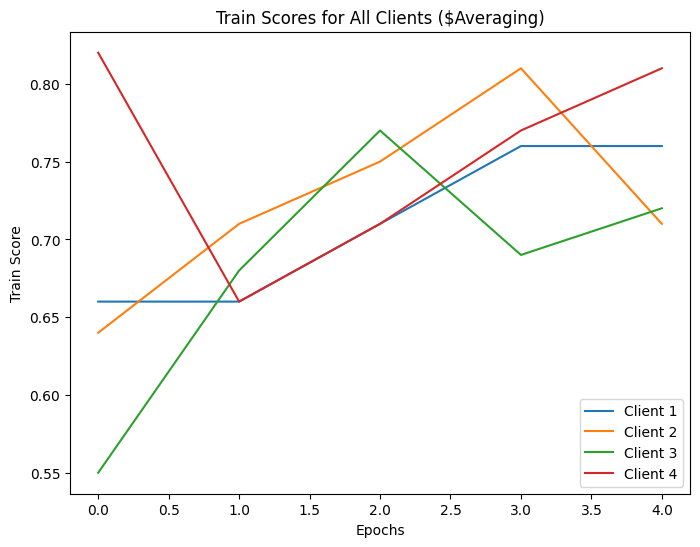

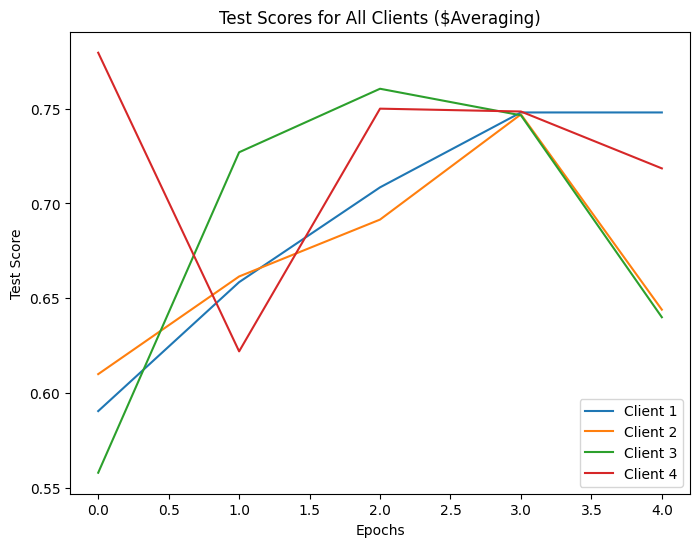

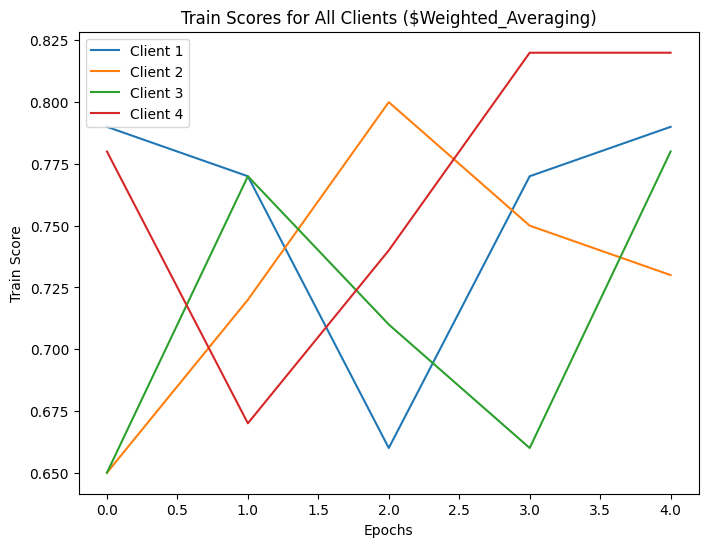

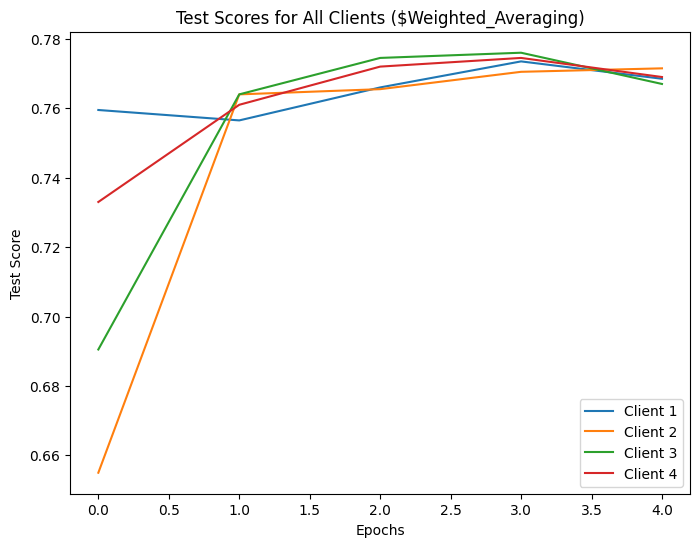

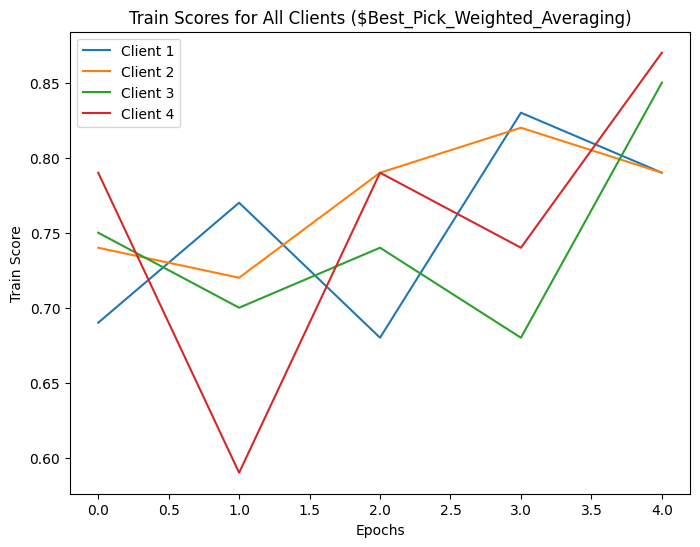

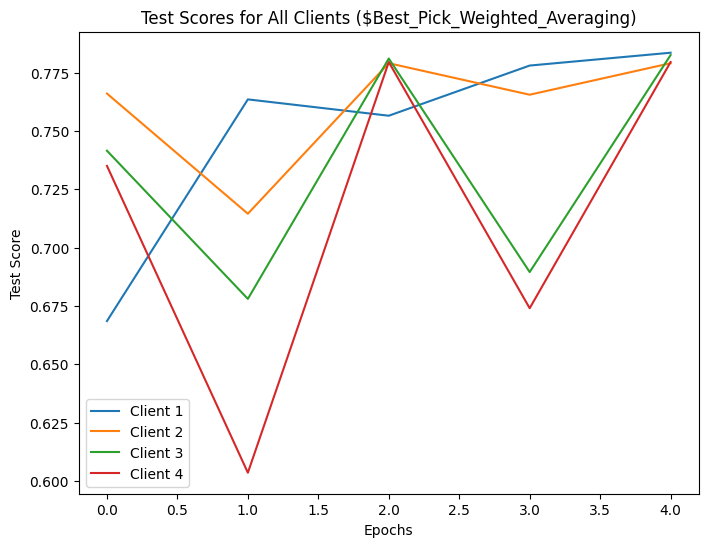

In [32]:
import matplotlib.pyplot as plt

# Create two figures, one for train scores and one for test scores

for idx, clients in enumerate(clients_2d_array):

  technique_name = list(fl_techniques.keys())[idx]
  # Create a new figure for test scores
  plt.figure(figsize=(8, 6))

  # Plot train scores for all clients
  for client in clients:
      plt.plot(client.train_scores, label=f'Client {clients.index(client) + 1}')

  plt.xlabel('Epochs')
  plt.ylabel('Train Score')
  plt.title(f"Train Scores for All Clients (${technique_name})")
  plt.legend()

  # Show the train scores plot
  plt.show()

  # Create a new figure for test scores
  plt.figure(figsize=(8, 6))

  # Plot test scores for all clients
  for client in clients:
      plt.plot(client.test_scores, label=f'Client {clients.index(client) + 1}')

  plt.xlabel('Epochs')
  plt.ylabel('Test Score')
  plt.title(f"Test Scores for All Clients (${technique_name})")
  plt.legend()

  # Show the test scores plot
  plt.show()


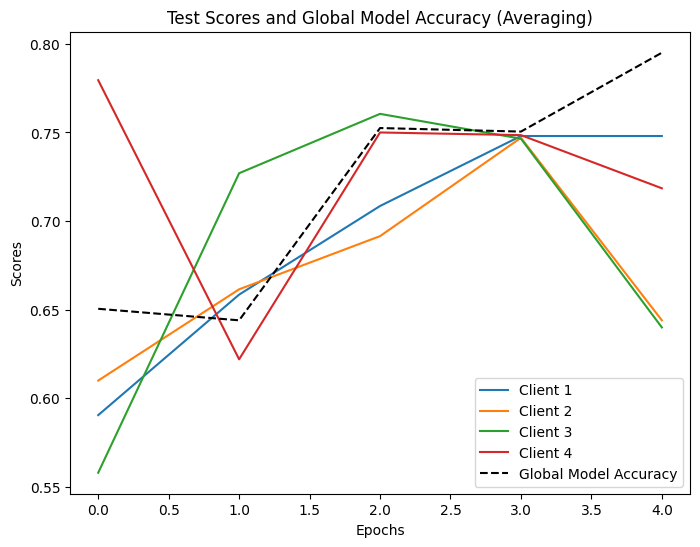

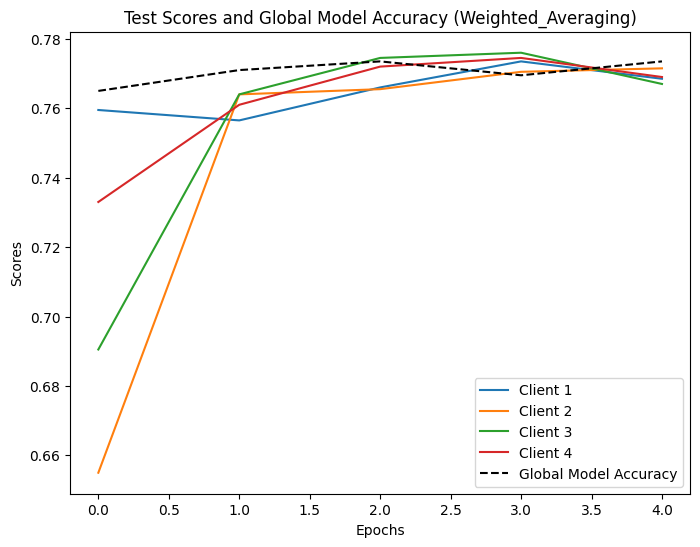

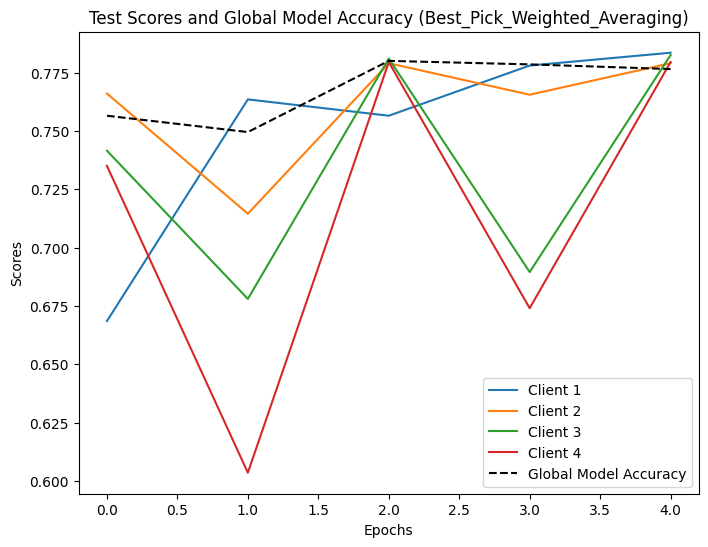

In [33]:
import matplotlib.pyplot as plt


for idx, clients in enumerate(clients_2d_array):

  technique_name = list(fl_techniques.keys())[idx]
  # Create a new figure for test scores
  plt.figure(figsize=(8, 6))


  # Plot test scores for all clients
  for client in clients:
      plt.plot(client.test_scores, label=f'Client {clients.index(client) + 1}')

  # Plot global model accuracy
  plt.plot(global_model_accuracy[idx], label='Global Model Accuracy', linestyle='--', color='black')

  plt.xlabel('Epochs')
  plt.ylabel('Scores')
  plt.title(f"Test Scores and Global Model Accuracy ({technique_name})")
  plt.legend()

  # Show the combined graph
  plt.show()


In [34]:
np_final_test_data = np_data_set[10000:]

final_test_image = [data_point["image"] for data_point in np_final_test_data]
final_test_labels = [data_point["label"] for data_point in np_final_test_data]
final_test_image = np.array(final_test_image)
final_test_labels = np.array(final_test_labels)

def getFinalAccuracy(weights):
        num_features = len(test_image[0])
        feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
        ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
        optimizer = COBYLA(maxiter=0)
        vqc = VQC(
            feature_map=feature_map,
            ansatz=ansatz,
            optimizer=optimizer,
            initial_point = weights,
            sampler=BackendSampler(backend=backend)
        )
        vqc.fit(test_image[:25], test_labels[:25])
        return vqc.score(final_test_image, final_test_labels)

In [35]:
final_results = []
for idx, row in enumerate(global_model_weights):
  final_results.append([])
  for global_model_weight in row:
    final_results[idx].append(getFinalAccuracy(global_model_weight))
print(final_results)

[[0.658, 0.6445, 0.747, 0.7465, 0.785], [0.7615, 0.766, 0.7675, 0.7715, 0.777], [0.7595, 0.757, 0.7805, 0.7795, 0.781]]


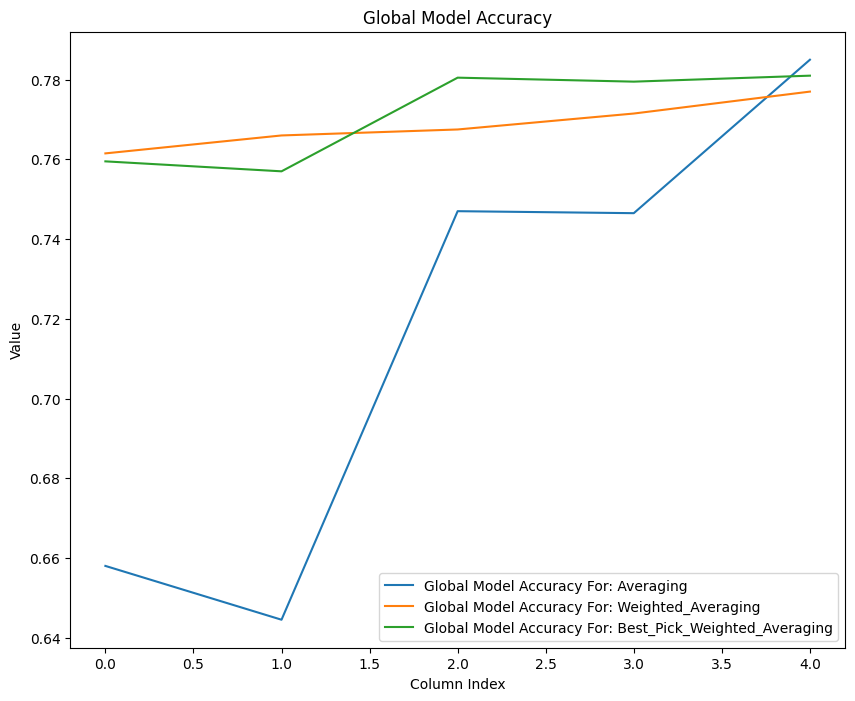

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming final_results is a 2D array containing your data
final_results = np.array(final_results)  # Convert final_results to a NumPy array

plt.figure(figsize=(10, 8))

# Iterate through each row and plot it
for row_index in range(final_results.shape[0]):
    data_row = final_results[row_index]
    technique_name = list(fl_techniques.keys())[row_index]
    plt.plot(data_row, label=f'Global Model Accuracy For: {technique_name}')

plt.xlabel('Column Index')
plt.ylabel('Value')
plt.title('Global Model Accuracy')
plt.legend()
plt.show()
